In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample
from sklearn.model_selection import KFold

In [2]:
# Load the county sentiment dataset
county_path = '../result-regression-data/county_sentiment.csv'
county = pd.read_csv(county_path)

county

,county,state,Pre-COVID_review_count,Pre-COVID_average_sentiment,During-COVID_review_count,During-COVID_average_sentiment,Post-COVID_review_count,Post-COVID_average_sentiment
0,Anchorage,Alaska,39.0,0.179487,23.0,-0.347826,134.0,-0.022388
1,Clark,Nevada,521.0,-0.032630,271.0,-0.243542,1420.0,-0.040141
2,Washoe,Nevada,95.0,-0.021053,81.0,-0.123457,324.0,-0.046296
3,Yellowstone,Montana,22.0,0.181818,11.0,-0.181818,154.0,-0.077922
4,Johnson,Kansas,121.0,0.049587,115.0,-0.121739,526.0,-0.066540
...,...,...,...,...,...,...,...,...
525,Arapahoe,Colorado,125.0,-0.024000,130.0,-0.169231,521.0,-0.055662
526,El Paso,Colorado,143.0,-0.132867,131.0,-0.129771,706.0,-0.022663
527,Mesa,Colorado,25.0,0.080000,13.0,-0.230769,195.0,-0.041026
528,Larimer,Colorado,84.0,-0.023810,61.0,-0.032787,382.0,0.002618


In [3]:
# Rename columns 'county' to 'County_Name' and 'state' to 'State_Name'
county.rename(columns={'county': 'County_Name', 'state': 'State_Name'}, inplace=True)

# Append 'County' to each value in the 'County_Name' column
county['County_Name'] = county['County_Name'] + ' County'

county

,County_Name,State_Name,Pre-COVID_review_count,Pre-COVID_average_sentiment,During-COVID_review_count,During-COVID_average_sentiment,Post-COVID_review_count,Post-COVID_average_sentiment
0,Anchorage County,Alaska,39.0,0.179487,23.0,-0.347826,134.0,-0.022388
1,Clark County,Nevada,521.0,-0.032630,271.0,-0.243542,1420.0,-0.040141
2,Washoe County,Nevada,95.0,-0.021053,81.0,-0.123457,324.0,-0.046296
3,Yellowstone County,Montana,22.0,0.181818,11.0,-0.181818,154.0,-0.077922
4,Johnson County,Kansas,121.0,0.049587,115.0,-0.121739,526.0,-0.066540
...,...,...,...,...,...,...,...,...
525,Arapahoe County,Colorado,125.0,-0.024000,130.0,-0.169231,521.0,-0.055662
526,El Paso County,Colorado,143.0,-0.132867,131.0,-0.129771,706.0,-0.022663
527,Mesa County,Colorado,25.0,0.080000,13.0,-0.230769,195.0,-0.041026
528,Larimer County,Colorado,84.0,-0.023810,61.0,-0.032787,382.0,0.002618


In [4]:
# Load the 'socioeconomic' data
socioeconomic_path = '../socio-economic-data/county socioeconomic.csv'
socioeconomic = pd.read_csv(socioeconomic_path)

socioeconomic

,Unnamed: 0,CTFIPS,Total_Population,LUM_Race,Median_income,Rent_to_Income,GINI,Agriculture_R,Mining_R,Construction_R,...,Asian_Non_Hispanic_R,White_Hispanic_R,Associate_R,Bachelor_R,Master_R,Professional_R,Doctorate_R,Population_Density,Education_Degree_R,Unemployed_R
0,0,1001,55380.0,0.424633,58731.0,29.4,0.4542,0.517902,0.354783,6.072099,...,1.034670,2.188516,8.405813,16.107796,7.693955,1.335403,1.434421,93.162770,26.571574,3.612784
1,1,1003,212830.0,0.329436,58320.0,28.7,0.4587,0.952772,0.257648,8.585460,...,0.918574,3.133017,9.447297,21.044656,7.816719,1.927047,1.074038,133.870337,31.862460,4.247450
2,2,1005,25361.0,0.559305,32525.0,29.6,0.4883,5.717342,0.000000,6.810888,...,0.477111,0.989709,7.203295,7.609664,2.755511,0.712536,0.501002,28.656251,11.578713,9.166487
3,3,1007,22493.0,0.365166,47542.0,29.4,0.4487,1.967330,1.895791,9.848575,...,0.120037,2.262926,7.354033,6.451014,3.018308,0.494805,0.414399,36.135592,10.378525,7.284988
4,4,1009,57681.0,0.142219,49358.0,27.3,0.4570,1.446366,0.634211,9.718483,...,0.367539,8.566079,12.530472,8.625066,3.500792,0.668493,0.299063,89.451422,13.093413,3.359014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,3103,56037,43521.0,0.200621,74843.0,23.1,0.4065,0.353702,14.129474,6.296831,...,0.739873,13.827807,12.066376,14.791503,5.589729,1.273156,0.844003,4.173885,22.498391,6.090794
3104,3104,56039,23280.0,0.267110,84678.0,25.8,0.5003,2.758143,0.949411,9.383229,...,1.250000,7.946735,4.473821,38.948219,13.848641,2.314842,1.893436,5.824595,57.005138,1.076301
3105,3105,56041,20479.0,0.172587,63403.0,23.9,0.3861,1.807618,10.888745,8.650742,...,0.156258,5.903609,10.421166,11.053687,4.296513,0.485961,0.192842,9.837539,16.029003,6.270129
3106,3106,56043,8027.0,0.263011,54158.0,25.0,0.3868,6.142441,4.077310,8.075192,...,0.000000,7.848511,10.097367,15.398485,6.076451,1.568698,0.342589,3.585606,23.386224,3.909622


In [5]:
# Select only the useful columns from the socioeconomic df
socioeconomic_columns = [
    'County_Name', 'State_Name', 'Democrat_R', 'Republican_R', 'Total_Population', 'Median_income',
    'GINI', 'No_Insurance_R', 'Household_Below_Poverty_R', 'HISPANIC_LATINO_R', 'White_R', 'Black_R', 
    'Indian_R', 'Asian_R', 'Under_18_R', 'Bt_18_44_R', 'Bt_45_64_R', 'Over_65_R', 'Male_R', 
    'Bachelor_R', 'Education_Degree_R', 'Population_Density', 'Unemployed_R'
]
socioeconomic = socioeconomic[socioeconomic_columns]

socioeconomic

,County_Name,State_Name,Democrat_R,Republican_R,Total_Population,Median_income,GINI,No_Insurance_R,Household_Below_Poverty_R,HISPANIC_LATINO_R,...,Asian_R,Under_18_R,Bt_18_44_R,Bt_45_64_R,Over_65_R,Male_R,Bachelor_R,Education_Degree_R,Population_Density,Unemployed_R
0,Autauga County,Alabama,23.769671,72.766588,55380.0,58731.0,0.4542,7.068485,14.712343,2.825930,...,1.034670,23.844348,34.615385,26.583604,14.956663,48.634886,16.107796,26.571574,93.162770,3.612784
1,Baldwin County,Alabama,19.385601,76.545712,212830.0,58320.0,0.4587,8.881862,10.493019,4.562797,...,0.925152,21.723911,30.662501,27.630033,19.983555,48.628483,21.044656,31.862460,133.870337,4.247450
2,Barbour County,Alabama,46.527844,52.096666,25361.0,32525.0,0.4883,11.319244,27.501338,4.357084,...,0.528370,20.925831,34.580655,25.921691,18.571823,52.919838,7.609664,11.578713,28.656251,9.166487
3,Bibb County,Alabama,21.249575,76.403220,22493.0,47542.0,0.4487,10.667895,18.371789,2.574134,...,0.120037,20.588628,35.033121,28.444405,15.933846,54.016805,6.451014,10.378525,36.135592,7.284988
4,Blount County,Alabama,8.425825,89.334844,57681.0,49358.0,0.4570,10.764283,14.208279,9.261282,...,0.367539,23.212150,32.251521,26.634420,17.901909,49.401016,8.625066,13.093413,89.451422,3.359014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,Sweetwater County,Wyoming,18.861646,70.951547,43521.0,74843.0,0.4065,11.254220,12.246344,15.884286,...,0.781232,26.532019,36.796030,25.247582,11.424370,51.632545,14.791503,22.498391,4.173885,6.090794
3104,Teton County,Wyoming,57.923497,31.052507,23280.0,84678.0,0.5003,12.746069,4.756625,15.025773,...,1.250000,19.063574,41.778351,25.120275,14.037801,52.942440,38.948219,57.005138,5.824595,1.076301
3105,Uinta County,Wyoming,14.191263,72.656434,20479.0,63403.0,0.3861,11.197673,9.990786,9.131305,...,0.156258,29.166463,32.677377,25.142829,13.013331,50.813028,11.053687,16.029003,9.837539,6.270129
3106,Washakie County,Wyoming,13.948610,76.324069,8027.0,54158.0,0.3868,15.019060,8.974740,14.226984,...,0.000000,24.641834,28.429052,25.837797,21.091317,50.641585,15.398485,23.386224,3.585606,3.909622


In [6]:
# Merge the 'socioeconomic' and 'county' DataFrames on 'County_Name' and 'State_Name'
df = pd.merge(socioeconomic, county, on=['County_Name', 'State_Name'], how='inner')
file_path = '../result-regression-data/gis_plot_data.csv'
df.to_csv(file_path, index=False)
df

,County_Name,State_Name,Democrat_R,Republican_R,Total_Population,Median_income,GINI,No_Insurance_R,Household_Below_Poverty_R,HISPANIC_LATINO_R,...,Bachelor_R,Education_Degree_R,Population_Density,Unemployed_R,Pre-COVID_review_count,Pre-COVID_average_sentiment,During-COVID_review_count,During-COVID_average_sentiment,Post-COVID_review_count,Post-COVID_average_sentiment
0,Baldwin County,Alabama,19.385601,76.545712,212830.0,58320.0,0.4587,8.881862,10.493019,4.562797,...,21.044656,31.862460,133.870337,4.247450,52.0,0.211538,44.0,-0.113636,252.0,-0.023810
1,Houston County,Alabama,25.009967,72.065480,104702.0,47580.0,0.4832,10.506384,17.343746,3.322764,...,13.410158,21.706672,180.565666,6.392454,19.0,-0.315789,11.0,-0.181818,82.0,-0.073171
2,Jefferson County,Alabama,51.570559,44.303743,659680.0,53901.0,0.5009,9.220432,16.069303,3.874151,...,20.354958,33.379953,593.549812,6.461221,112.0,-0.160714,44.0,-0.022727,415.0,-0.057831
3,Madison County,Alabama,38.449345,54.789490,362276.0,65449.0,0.4620,8.307279,12.466512,4.948713,...,25.972716,42.757104,451.946203,4.978116,43.0,0.046512,28.0,-0.178571,280.0,0.000000
4,Mobile County,Alabama,41.789541,55.064057,414114.0,47583.0,0.4760,11.242838,18.051724,2.902099,...,15.414685,23.199492,336.839648,5.807724,67.0,-0.238806,29.0,-0.241379,281.0,-0.028470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,Sheboygan County,Wisconsin,38.481267,54.409521,115178.0,60696.0,0.4092,4.020897,7.289790,6.367535,...,17.625670,25.127763,225.164762,3.115710,18.0,-0.222222,14.0,0.071429,157.0,-0.044586
494,Walworth County,Wisconsin,36.446886,56.213467,103074.0,63776.0,0.4328,6.562259,11.777658,11.090091,...,18.253922,28.789437,185.578839,3.786781,11.0,-0.636364,11.0,-0.363636,105.0,-0.019048
495,Washington County,Wisconsin,26.736151,66.316680,134925.0,77663.0,0.4068,3.780561,5.196862,3.164721,...,22.211015,31.452647,313.310143,2.889117,22.0,-0.136364,28.0,-0.250000,194.0,0.000000
496,Waukesha County,Wisconsin,33.132253,59.621740,400475.0,87277.0,0.4451,2.696705,5.392675,4.719645,...,29.118980,44.466380,728.506387,2.925257,77.0,-0.025974,59.0,-0.169492,442.0,-0.033937


/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_36417/3162788252.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Pre-Pandemic', 'Peak-Pandemic', 'Post-Peak'],


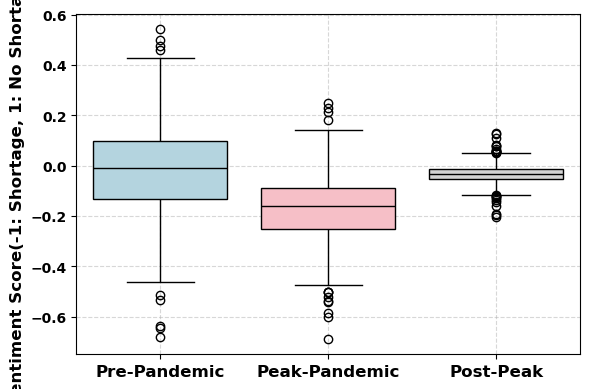

In [1]:
# Create the figure and axis with matching figure size
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
# Create boxplots with custom colors and black lines
sns.boxplot(data=df_merged[['Pre-COVID_average_sentiment', 
                           'During-COVID_average_sentiment', 
                           'Post-COVID_average_sentiment']],
            ax=ax,
            palette=['lightblue', 'lightpink', '#D3D3D3'],
            boxprops=dict(edgecolor='black'),  # Box edge color
            whiskerprops=dict(color='black'),  # Whisker color
            capprops=dict(color='black'),      # Cap color
            medianprops=dict(color='black'),   # Median line color
            flierprops=dict(color='black', markeredgecolor='black'))  # Outlier color
# Set labels and titles with bold formatting
ax.set_ylabel('Sentiment Score(-1: Shortage, 1: No Shortage)', fontsize=12, fontweight='bold')
# Set x-tick labels with bold formatting
ax.set_xticklabels(['Pre-Pandemic', 'Peak-Pandemic', 'Post-Peak'], 
                   fontsize=12, 
                   fontweight='bold')  # Added bold to tick labels
# Adjust tick parameters and make tick labels bold
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')
# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.5)
# Adjust layout
plt.tight_layout()
# Save the figure with increased dpi to improve clarity
plt.savefig('sentiment_boxplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [8]:
# Extract independent variables and perform standardization
X = df[['Democrat_R', 'Republican_R', 'Total_Population', 'Median_income', 'GINI', 'No_Insurance_R', 
        'Household_Below_Poverty_R', 'HISPANIC_LATINO_R', 'White_R', 'Black_R', 'Indian_R', 'Asian_R', 
        'Under_18_R', 'Bt_18_44_R', 'Bt_45_64_R', 'Over_65_R', 'Male_R', 'Bachelor_R',
        'Education_Degree_R', 'Population_Density', 'Unemployed_R']].fillna(0)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

y_pre = df['Pre-COVID_average_sentiment'].fillna(0)
y_during = df['During-COVID_average_sentiment'].fillna(0)
y_post = df['Post-COVID_average_sentiment'].fillna(0)

# Create DataFrame after standardization
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate and display VIF
vif_data = calculate_vif(X_scaled_df)

vif_data

/Users/liuguanhong/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,Democrat_R,41.104193
1,Republican_R,35.097853
2,Total_Population,1.549532
3,Median_income,11.410688
4,GINI,3.547619
5,No_Insurance_R,2.999569
6,Household_Below_Poverty_R,8.923974
7,HISPANIC_LATINO_R,5.770566
8,White_R,24.025513
9,Black_R,17.701124


In [9]:
# PLS

# Define root_mean_squared_error function
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# PLS regression function with p-value and standard error
def pls_regression(X, y, n_permutations=1000):
    pls = PLSRegression(n_components=5)
    pls.fit(X, y)
    coefficients = pls.coef_.ravel()
    
    # R² and RMSE calculation
    y_pred = pls.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    
    # Permutation testing for p-values and standard errors
    p_values, std_errors = [], []
    for i in range(X.shape[1]):
        original_score = np.corrcoef(X[:, i], y.ravel())[0, 1]
        permuted_scores = [np.corrcoef(X[:, i], resample(y).ravel())[0, 1] for _ in range(n_permutations)]
        p_value = np.sum(np.abs(permuted_scores) >= np.abs(original_score)) / n_permutations
        std_error = np.std(permuted_scores)
        p_values.append(p_value)
        std_errors.append(std_error)
    
    return coefficients, p_values, std_errors, r2, rmse


y_pre = df['Pre-COVID_average_sentiment'].fillna(0)
y_during = df['During-COVID_average_sentiment'].fillna(0)
y_post = df['Post-COVID_average_sentiment'].fillna(0)

# Run PLS regression for each period
results = {}
for period, y in zip(['Pre', 'During', 'Post'], [y_pre, y_during, y_post]):
    coeffs, pvals, stderrs, r2, rmse = pls_regression(X_scaled, y.values.reshape(-1, 1))
    results[period] = (coeffs, pvals, stderrs)
    print(f'{period}-Pandemic R²: {r2:.3f}')
    print(f'{period}-Pandemic RMSE: {rmse:.3f}')

# Create DataFrames for each period
columns = X.columns
df_pre = pd.DataFrame({'Coefficient': results['Pre'][0], 
                       'P-Value': results['Pre'][1], 
                       'Standard Error': results['Pre'][2]}, index=columns).add_prefix('Pre-Pandemic ')

df_during = pd.DataFrame({'Coefficient': results['During'][0], 
                          'P-Value': results['During'][1], 
                          'Standard Error': results['During'][2]}, index=columns).add_prefix('During-Pandemic ')

df_post = pd.DataFrame({'Coefficient': results['Post'][0], 
                        'P-Value': results['Post'][1], 
                        'Standard Error': results['Post'][2]}, index=columns).add_prefix('Post-Pandemic ')

# Concatenate results and round to 3 decimal places
df_pls = pd.concat([df_pre, df_during, df_post], axis=1).round(3)

df_pls

Pre-Pandemic R²: 0.135
Pre-Pandemic RMSE: 0.171
During-Pandemic R²: 0.142
During-Pandemic RMSE: 0.125
Post-Pandemic R²: 0.087
Post-Pandemic RMSE: 0.038


,Pre-Pandemic Coefficient,Pre-Pandemic P-Value,Pre-Pandemic Standard Error,During-Pandemic Coefficient,During-Pandemic P-Value,During-Pandemic Standard Error,Post-Pandemic Coefficient,Post-Pandemic P-Value,Post-Pandemic Standard Error
Democrat_R,0.023,0.057,0.044,0.008,0.005,0.045,-0.003,0.022,0.044
Republican_R,-0.025,0.025,0.045,-0.017,0.002,0.046,-0.001,0.002,0.045
Total_Population,0.004,0.701,0.044,0.008,0.779,0.044,-0.001,0.595,0.045
Median_income,-0.018,0.599,0.044,-0.013,0.010,0.044,0.002,0.005,0.046
GINI,0.016,0.064,0.046,-0.015,0.862,0.046,0.002,0.116,0.043
No_Insurance_R,-0.020,0.000,0.046,-0.023,0.000,0.045,-0.005,0.001,0.046
Household_Below_Poverty_R,-0.007,0.990,0.045,0.000,0.006,0.044,-0.001,0.099,0.045
HISPANIC_LATINO_R,-0.024,0.056,0.045,-0.018,0.000,0.045,0.002,0.287,0.044
White_R,0.024,0.000,0.044,0.000,0.674,0.044,-0.002,0.632,0.044
Black_R,-0.045,0.000,0.045,-0.008,0.240,0.046,-0.003,0.358,0.044


In [10]:
# During - Before

# Define y_diff for the difference between during-pandemic and pre-pandemic sentiment
y_diff_during_before = df['During-COVID_average_sentiment'].fillna(0) - df['Pre-COVID_average_sentiment'].fillna(0)

# Function to perform PLS regression without cross-validation, only with permutation testing
def pls_regression_with_permutation(X, y, n_permutations=1000):
    pls = PLSRegression(n_components=5)
    pls.fit(X, y)
    coefficients = pls.coef_.ravel()

    # R² and RMSE calculation
    y_pred = pls.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    
    # Permutation testing for p-values and standard errors
    p_values = []
    std_errors = []
    for i in range(X.shape[1]):
        original_score = np.corrcoef(X[:, i], y.ravel())[0, 1]
        permuted_scores = [np.corrcoef(X[:, i], resample(y).ravel())[0, 1] for _ in range(n_permutations)]
        p_value = (np.sum(np.abs(permuted_scores) >= np.abs(original_score))) / n_permutations
        std_error = np.std(permuted_scores)
        p_values.append(p_value)
        std_errors.append(std_error)
    
    return coefficients, p_values, std_errors, r2, rmse

# Run PLS regression for the difference
coeff_diff, pval_diff, stderr_diff, r2_diff, rmse_diff = pls_regression_with_permutation(X_scaled, y_diff_during_before.values.reshape(-1, 1))

# Print R² and RMSE results
print(f'During-Before R²: {r2_diff:.3f}')
print(f'During-Before RMSE: {rmse_diff:.3f}')

# Create a DataFrame to hold the results
columns = X.columns
df_diff_during_before = pd.DataFrame({'Coefficient': coeff_diff, 'P-Value': pval_diff, 'Standard Error': stderr_diff}, index=columns).round(3)

df_diff_during_before

During-Before R²: 0.069
During-Before RMSE: 0.207


,Coefficient,P-Value,Standard Error
Democrat_R,-0.021,0.963,0.045
Republican_R,0.006,0.937,0.046
Total_Population,0.010,0.646,0.046
Median_income,-0.001,0.056,0.045
GINI,-0.048,0.075,0.044
No_Insurance_R,-0.012,0.777,0.047
Household_Below_Poverty_R,0.026,0.090,0.045
HISPANIC_LATINO_R,0.020,0.282,0.045
White_R,-0.026,0.003,0.045
Black_R,0.048,0.004,0.044


In [11]:
# Post - During
# Define y_diff for the difference between Post-Pandemic and During-Pandemic sentiment
y_diff_post_during = df['Post-COVID_average_sentiment'].fillna(0) - df['During-COVID_average_sentiment'].fillna(0)

# Function to perform PLS regression without cross-validation, with permutation testing
def pls_regression_with_permutation_only(X, y, n_permutations=1000):
    pls = PLSRegression(n_components=5)
    pls.fit(X, y)
    coefficients = pls.coef_.ravel()

    # R² and RMSE calculation
    y_pred = pls.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    
    # Permutation testing for p-values and standard errors
    p_values = []
    std_errors = []
    for i in range(X.shape[1]):
        original_score = np.corrcoef(X[:, i], y.ravel())[0, 1]
        permuted_scores = [np.corrcoef(X[:, i], resample(y).ravel())[0, 1] for _ in range(n_permutations)]
        p_value = (np.sum(np.abs(permuted_scores) >= np.abs(original_score))) / n_permutations
        std_error = np.std(permuted_scores)
        p_values.append(p_value)
        std_errors.append(std_error)
    
    return coefficients, p_values, std_errors, r2, rmse

# Run PLS regression for the difference
coeff_diff_post_during, pval_diff_post_during, stderr_diff_post_during, r2_diff_post_during, rmse_diff_post_during = pls_regression_with_permutation_only(X_scaled, y_diff_post_during.values.reshape(-1, 1))

# Print R² and RMSE results
print(f'Post-During R²: {r2_diff_post_during:.3f}')
print(f'Post-During RMSE: {rmse_diff_post_during:.3f}')

# Create a DataFrame to hold the results
columns = X.columns
df_diff_post_during = pd.DataFrame({'Coefficient': coeff_diff_post_during, 'P-Value': pval_diff_post_during, 'Standard Error': stderr_diff_post_during}, index=columns).round(3)

df_diff_post_during

Post-During R²: 0.119
Post-During RMSE: 0.127


,Coefficient,P-Value,Standard Error
Democrat_R,-0.010,0.047,0.044
Republican_R,0.017,0.014,0.043
Total_Population,-0.010,0.904,0.045
Median_income,0.015,0.091,0.044
GINI,0.017,0.517,0.045
No_Insurance_R,0.018,0.000,0.046
Household_Below_Poverty_R,-0.001,0.023,0.043
HISPANIC_LATINO_R,0.019,0.000,0.045
White_R,-0.002,0.584,0.046
Black_R,0.005,0.351,0.045
